# Ch 2. 監督式學習：迴歸
## 2-3. 正規化的迴歸
 - [脊迴歸](#sec1)  
 - [套索迴歸](#sec2)
 - [彈性網](#sec3)  
***

<a id='sec1'></a>
## 脊迴歸

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

house = load_boston()
df = pd.DataFrame(data=house.data, 
                  columns=house.feature_names)
df['MEDV'] = house.target

# 進行標準化
scalar = StandardScaler()
X = scalar.fit_transform(df.iloc[:, :-1])
y = scalar.fit_transform(df.loc[:, ['MEDV']])
X[:1, :]

array([[-0.41978194,  0.28482986, -1.2879095 , -0.27259857, -0.14421743,
         0.41367189, -0.12001342,  0.1402136 , -0.98284286, -0.66660821,
        -1.45900038,  0.44105193, -1.0755623 ]])

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
plt.style.use('fivethirtyeight')

# 利用交叉驗證找出最佳 alpha
alphas = np.logspace(-3, 3, 50)
reg_cv = RidgeCV(alphas, store_cv_values=True)
reg_cv.fit(X, y)
print('Best alpha: %.3f' % reg_cv.alpha_)

Best alpha: 4.715


(0.001, 1000.0)

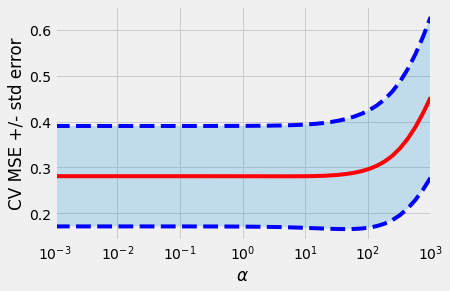

In [3]:
scores = np.mean(reg_cv.cv_values_, axis=0)[0]
scores_std = np.std(reg_cv.cv_values_, axis=0)[0]

# 設定 x 軸為對數
plt.semilogx(alphas, scores, color='red')

# 繪製 MSE +/- 標準誤(std error)
std_error = scores_std / np.sqrt(len(scores))
plt.semilogx(alphas, scores+std_error, 'b--')
plt.semilogx(alphas, scores-std_error, 'b--')
plt.fill_between(alphas, scores+std_error, 
                 scores-std_error, alpha=0.2)

plt.ylabel('CV MSE +/- std error')
plt.xlabel(r'$\alpha$')
plt.xlim([alphas[0], alphas[-1]])

In [4]:
from sklearn.metrics import mean_squared_error

reg = Ridge(alpha=reg_cv.alpha_)
y_pred = reg.fit(X, y).predict(X)
print('MSE =', mean_squared_error(y, y_pred))

MSE = 0.2595894891187877


In [5]:
# 因為已經標準化，所以把截距拿掉
model = Ridge(alpha=reg_cv.alpha_,
              fit_intercept=False)
model.fit(X, y)
df_coef = pd.DataFrame(data=model.coef_, 
                       columns=df.columns[:-1])
df_coef

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.097095,0.110543,0.004554,0.075748,-0.210387,0.295029,-0.000851,-0.324567,0.25692,-0.195713,-0.220271,0.09221,-0.401026


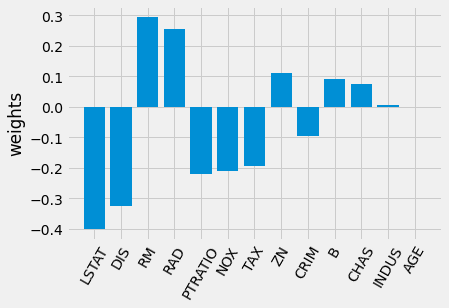

In [6]:
coef = np.array(df_coef)[0]
# 依迴歸係數的絕對值排序(由大到小)
coef_abs = np.apply_along_axis(abs, 0, coef)
idx = np.argsort(-coef_abs)

plt.bar(range(len(coef)), coef[idx])
plt.xticks(range(len(coef)), df_coef.columns[idx], 
           rotation=60)
plt.ylabel('weights');

<a id='sec2'></a>
## 套索迴歸

In [7]:
from sklearn.linear_model import LassoCV, Lasso

alphas = np.logspace(-5, 3, 50)
reg_cv = LassoCV(alphas=alphas, cv=10, n_jobs=-1)
reg_cv.fit(X, y.reshape(-1))
print('Best alpha: %.3f' % reg_cv.alpha_)

Best alpha: 0.018


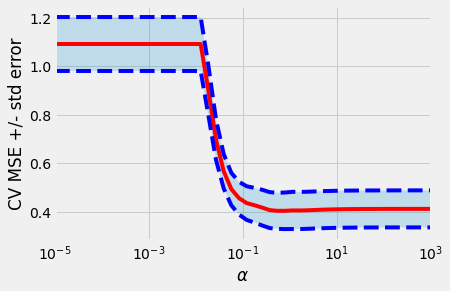

In [8]:
scores = np.mean(reg_cv.mse_path_, axis=1)
scores_std = np.std(reg_cv.mse_path_, axis=1)

# 設定 x 軸為對數
plt.semilogx(alphas, scores, color='red')

# 繪製 MSE +/- 標準誤(std error)
std_error = scores_std / np.sqrt(len(scores))
plt.semilogx(alphas, scores+std_error, 'b--')
plt.semilogx(alphas, scores-std_error, 'b--')
plt.fill_between(alphas, scores+std_error, 
                 scores-std_error, alpha=0.2)

plt.ylabel('CV MSE +/- std error')
plt.xlabel(r'$\alpha$')
plt.xlim([alphas[0], alphas[-1]]);

In [9]:
# 因為已經標準化，所以把截距拿掉
model = Lasso(alpha=reg_cv.alpha_,
              fit_intercept=False)
model.fit(X, y)
df_coef = pd.DataFrame(data=model.coef_.reshape(1,-1), 
                       columns=df.columns[:-1])
df_coef

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.046595,0.049176,-0.009904,0.069666,-0.135755,0.31885,-0.0,-0.211611,0.020489,-0.000186,-0.199043,0.076351,-0.404717


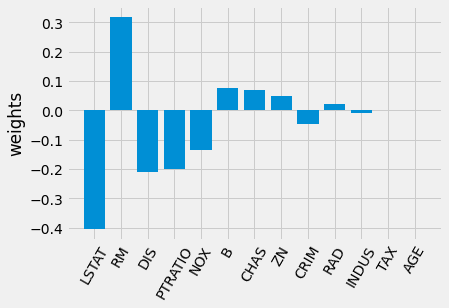

In [10]:
coef = np.array(df_coef)[0]
# 依迴歸係數的絕對值排序(由大到小)
coef_abs = np.apply_along_axis(abs, 0, coef)
idx = np.argsort(-coef_abs)

plt.bar(range(len(coef)), coef[idx])
plt.xticks(range(len(coef)), df_coef.columns[idx], 
           rotation=60)
plt.ylabel('weights');

<a id='sec3'></a>
## 彈性網

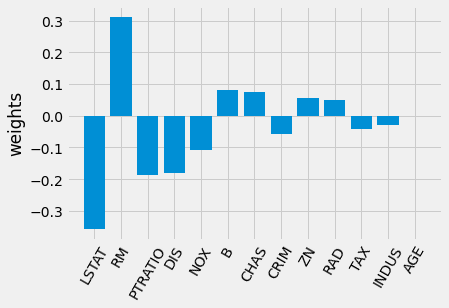

In [11]:
from sklearn.linear_model import ElasticNetCV
# 僅設定 rho 的範圍，alpha 的範圍採自動設定
rho = [.1, .5, .7, .9, .95, .99, 1]
reg_cv = ElasticNetCV(cv=10, l1_ratio=rho)
reg_cv.fit(X, y.reshape(-1))

df_coef = pd.DataFrame(data=reg_cv.coef_.reshape(1,-1), 
                       columns=df.columns[:-1])
coef = np.array(df_coef)[0]
# 依迴歸係數的絕對值排序(由大到小)
coef_abs = np.apply_along_axis(abs, 0, coef)
idx = np.argsort(-coef_abs)

plt.bar(range(len(coef)), coef[idx])
plt.xticks(range(len(coef)), df_coef.columns[idx], 
           rotation=60)
plt.ylabel('weights');